In [12]:
'''
Sources::::: 
https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk
https://www.tutorialspoint.com/matplotlib/matplotlib_bar_plot.htm

https://textblob.readthedocs.io/en/dev/quickstart.html#wordnet-integration -- spell check, word counts.
http://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm -- 

'''

'\nSources::::: \nhttps://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk\nhttps://www.tutorialspoint.com/matplotlib/matplotlib_bar_plot.htm\n\nhttps://textblob.readthedocs.io/en/dev/quickstart.html#wordnet-integration -- spell check, word counts.\nhttp://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm -- \n\n'

In [133]:
import nltk, re, string, random
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
nltk.download('twitter_samples')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import twitter_samples, stopwords
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import FreqDist, classify, NaiveBayesClassifier
from WNAffect import wnaffect,emotion
from Lexicon import Lexicon
import matplotlib.cm as cm
from matplotlib.colors import Normalize

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\SIDDHARTHA\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SIDDHARTHA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SIDDHARTHA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\SIDDHARTHA\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SIDDHARTHA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [50]:
def lemmatize_sentence(tokens):
    '''
    lemmatizing words, for e.g 'run', 'ran', 'running' is the same word.
    The lemmatizer conforms similar words to an equivalent form, or is transformed to its root form
    '''
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence

def remove_noise(tweet_tokens, stop_words = ()):
    '''
    Removing stop words like 'is', 'the' etc. lemmatize_sentence() function implementation is 
    reused here.
    '''
    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token

def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

In [51]:
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')
text = twitter_samples.strings('tweets.20150430-223406.json')
positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')



In [52]:
positive_cleaned_tokens_list = []
negative_cleaned_tokens_list = []
stop_words = stopwords.words('english')

for tokens in positive_tweet_tokens:
    positive_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

for tokens in negative_tweet_tokens:
    negative_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

print(positive_tweet_tokens[500])
print(positive_cleaned_tokens_list[500])

['Dang', 'that', 'is', 'some', 'rad', '@AbzuGame', '#fanart', '!', ':D', 'https://t.co/bI8k8tb9ht']
['dang', 'rad', '#fanart', ':d']


In [53]:
all_pos_words = get_all_words(positive_cleaned_tokens_list)
all_neg_words = get_all_words(negative_cleaned_tokens_list)
freq_dist_pos = FreqDist(all_pos_words)
freq_dist_neg = FreqDist(all_neg_words)

print(positive_cleaned_tokens_list[1])
print(positive_cleaned_tokens_list[2])

#print(freq_dist_pos.most_common(10))
#print(freq_dist_neg.most_common(10))

['hey', 'james', 'odd', ':/', 'please', 'call', 'contact', 'centre', '02392441234', 'able', 'assist', ':)', 'many', 'thanks']
['listen', 'last', 'night', ':)', 'bleed', 'amazing', 'track', 'scotland']


In [57]:
'''
For positive words!
'''


from Lexicon import Lexicon
positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)
negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)

#wna = WNAffect.WNAffect('wordnet-1.6/', 'wn-domains-3.2/')
#wna = wnaffect.WNAffect('wordnet-1.6/', 'wn-domains-3.2/')
#emo = wna.get_emotion('Kill','NN')
#print(emo)


emotion_fetcher = Lexicon.Lexicon("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/NRC-Sentiment-Emotion-Lexicons/NRC-Sentiment-Emotion-Lexicons/NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt")
#print(emotion_fetcher.get_emotion("shout"))
emotions_count_dict = {"anger":0,"anticipation":0,"disgust":0,"fear":0,"joy":0,"negative":0,"positive":0,"sadness":0,"surprise":0,"trust":0,"unclassified":0}


pos_count=0
emotions_list=[]
pos_word_list=[]
for tweet_dict in positive_tokens_for_model:
    for word,tag in pos_tag(tweet_dict):
        pos_word_list.append(word)
    pos_count+=1

print(pos_word_list)

for word in pos_word_list:
    for sentiment in emotion_fetcher.get_emotion(word):
        emotions_count_dict[sentiment]+=1


print(emotions_count_dict)
print(pos_count)

'post', 'fb', 'happy', 'friday', ':-)', 'visit', 'blog', 'thanks', ':d', 'everyone', 'fuckin', 'irritate', ':)', 'also', 'mean', 'imma', 'go', 'back', 'twitter', 'active', ':d', 'cause', 'know', 'everyone', 'miss', ';)', 'xd', 'hello', 'ladies', 'apologies', 'delay', 'please', 'dm', 'us', 'address', 'size', 'detail', "we'll", 'ship', 'prize', ':)', 'free', '5', 'voucher', 'twitter', 'friend', 'use', 'fiverr', ':)', 'oh', 'gina', 'busy', ':-)', "can't", 'wait', 'see', 'hear', 'xxx', '#soproud', 'happy', 'friday', 'everyone', 'hope', 'fantastic', 'week', ':)', '#friday', 'yes', 'one', 'team', ':)', 'happy', 'belated', 'birthday', 'sweetie', ':)', 'morning', 'emma', ':)', 'thanks', 'guys', ':)', 'would', 'say', ':-)', 'love', 'make', 'two', 'heart', 'one', ':)', 'thanks', 'add', 'us', 'list', ':)', 'make', 'sure', 'keep', 'touch', 'news', 'light', 'bulb', 'corn', 'waste', 'thanks', 'mrs', 'bee', 'xxx', ':-)', 'thankyou', ':)', 'close', 'enought', ':)', 'good', 'luck', '...', 'another', 'p

In [58]:
'''
for negative words
'''
from Lexicon import Lexicon
#positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)
#negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)

#wna = WNAffect.WNAffect('wordnet-1.6/', 'wn-domains-3.2/')
#wna = wnaffect.WNAffect('wordnet-1.6/', 'wn-domains-3.2/')
#emo = wna.get_emotion('Kill','NN')
#print(emo)


emotion_fetcher = Lexicon.Lexicon("C:/Users/SIDDHARTHA/Trinity/TextAnalysis/TextAnalysis/Sentimentalysis/NRC-Sentiment-Emotion-Lexicons/NRC-Sentiment-Emotion-Lexicons/NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt")
#print(emotion_fetcher.get_emotion("shout"))
emotions_count_dict = {"anger":0,"anticipation":0,"disgust":0,"fear":0,"joy":0,"negative":0,"positive":0,"sadness":0,"surprise":0,"trust":0,"unclassified":0}


neg_count=0
emotions_list=[]
neg_word_list=[]
for tweet_dict in negative_tokens_for_model:
    for word,tag in pos_tag(tweet_dict):
        neg_word_list.append(word)
    neg_count+=1

print(neg_word_list)

for word in neg_word_list:
    for sentiment in emotion_fetcher.get_emotion(word):
        emotions_count_dict[sentiment]+=1


print(emotions_count_dict)
print(neg_count)

ow', ':(', ':-(', 'please', 'notice', 'h', '😂', 'thank', 'san', '😀', 'wanna', 'change', 'avi', 'usanele', ':(', 'sad', 'day', 'nathan', ':(', 'noo', 'sad', 'time', ':(', 'ruby', 'replace', 'shuffling', 'act', 'get', 'excited', 'micha', 'rt', 'fave', 'tweet', 'creep', ':-(', 'anyone', 'wanna', 'friend', "i'm", 'lonely', 'girl', 'england', 'bore', 'hell', 'throughout', 'summer', 'holiday', '..', ':(', 'home', 'alone', ':(', 'whose', 'idea', 'ave', 'triple', 'business', 'lecture', 'friday', 'afternoon', '2-5', ':(', ':(', "that's", 'damn', 'lie', ':(', "i'm", 'allow', 'give', 'blood', ':(', 'six', 'month', 'ago', 'bottom', 'jaw', 'second', 'tooth', 'back', 'break', 'quarter', '...', 'thing', 'chew', 'gum', ':(', 'go', 'sleep', '12', 'last', 'night', 'rn', 'im', ':(', ':-(', 'please', 'notice', 'twitter', 'decide', 'take', 'feature', 'away', ':-(', "i'm", 'okay', 'tire', 'plan', 'go', 'today', 'rain', ':(', 'thats', 'push', 'emoji', 'give', 'sony', 'five', ':-(', 'late', ':(', '#followmeaa

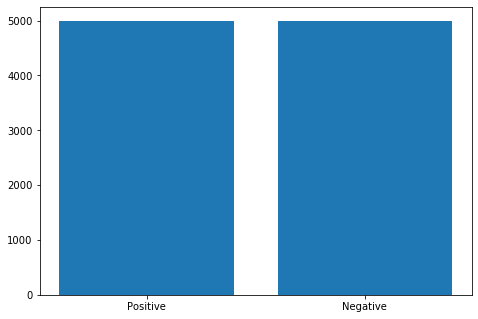

In [59]:
fig = plt.figure()
tweet_type = ['Positive','Negative']
tweet_counts = [pos_count,neg_count]
ax = fig.add_axes([0,0,1,1])
ax.bar(tweet_type,tweet_counts)
plt.show()

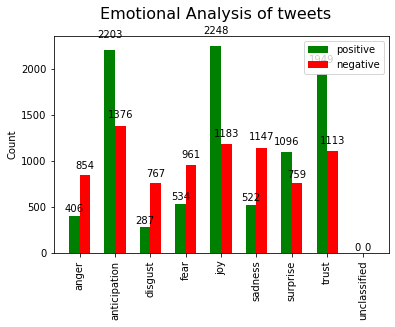

In [137]:

emotions_pos = {'anger': 406, 'anticipation': 2203, 'disgust': 287, 'fear': 534, 'joy': 2248, 'sadness': 522, 'surprise': 1096, 'trust': 1949, 'unclassified': 0}

emotions_neg = {'anger': 854, 'anticipation': 1376, 'disgust': 767, 'fear': 961, 'joy': 1183, 'sadness': 1147, 'surprise': 759, 'trust': 1113, 'unclassified': 0}

emotions_colors = {'anger': 'red', 'anticipation': 'purple', 'disgust': 'yellow', 'fear': 'indigo', 'joy': 'green', 'negative': 'black', 'positive': 'pink', 'sadness': 'blue', 'surprise': 'maroon', 'trust': 'orange', 'unclassified': 'cyan'}
#labels = list(emotions_colors.keys())
#handles = [plt.Rectangle((1,1),1,1, color=emotions_colors[label]) for label in labels]
my_cmap = cm.get_cmap('jet')
ind = np.arange(len(emotions_pos))
width=0.3
fig = plt.figure()
#figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
fig.suptitle('Emotional Analysis of tweets', fontsize=16)
ax = fig.add_subplot(111)
pos_bars=ax.bar(ind, list(emotions_pos.values()),width,color='g',align='center')
neg_bars=ax.bar(ind+width, list(emotions_neg.values()),width,color='r', align='center')
ax.set_ylabel('Count')
ax.set_xticklabels(list(emotions_pos.keys()), rotation=90)
ax.set_xticks(ind+width/2)
ax.legend( (pos_bars[0], neg_bars[0]), ('positive', 'negative') )

def autolabel(bars):
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x()+bar.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(pos_bars)
autolabel(neg_bars)

plt.show()

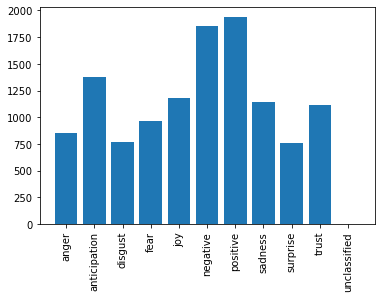

In [84]:
plt.bar(range(len(emotions_neg)), list(emotions_neg.values()), align='center')
plt.xticks(range(len(emotions_neg)), list(emotions_neg.keys()), rotation=90)
#plt.legend(handles, labels)
plt.show()

In [20]:
positive_dataset = [(tweet_dict, "Positive")
                     for tweet_dict in positive_tokens_for_model]

print(positive_dataset)
print(negative_dataset)

negative_dataset = [(tweet_dict, "Negative")
                     for tweet_dict in negative_tokens_for_model]

dataset = positive_dataset + negative_dataset

random.shuffle(dataset)

#70:30 split
train_data = dataset[:7000]
test_data = dataset[7000:]   

print(train_data)
print(test_data)

'xx': True}, 'Positive'), ({'bed': True, 'best': True, 'couple': True, 'ever': True, ':)': True}, 'Positive'), ({'favorite': True, 'apple': True, 'sauce': True, ':)': True}, 'Positive'), ({'nice': True, 'holiday': True, 'honey': True, ':-)': True, 'kisses': True}, 'Positive'), ({'follow': True, 'back': True, 'pleasse': True, ':)': True}, 'Positive'), ({'thakyou': True, 'sir': True, ':)': True}, 'Positive'), ({'thank': True, 'beatriz': True, ':)': True}, 'Positive'), ({'rt': True, 'bailona': True, 'group': True, 'chat': True, 'mention': True, 'approve': True, 'fanbase': True, ':)': True}, 'Positive'), ({'party': True, 'cancel': True, ':p': True, '#bajrangibhaijaanhighestweek1': True}, 'Positive'), ({'thanks': True, 'follow': True, ':-)': True, 'hope': True, 'great': True, 'week': True}, 'Positive'), ({'puff': True, 'pastry': True, 'egg': True, 'tart': True, 'hot': True, 'fresh': True, 'oven': True, ':)': True, 'wan': True, 'chai': True, 'mtr': True}, 'Positive'), ({'thank': True, 'follo

NameError: name 'negative_dataset' is not defined

In [ ]:
classifier = NaiveBayesClassifier.train(train_data)

In [ ]:
print("Accuracy is:", classify.accuracy(classifier, test_data))
print(classifier.show_most_informative_features(10))